# Basin Scale GW Modeling

### Scenario Analysis 

GroMore is proposing to start a new agricultural effort in the basin. Their proposal is included in the base model as the rectangular irrigated area with the elevated ET and the shallow pumping well. They are resistant to changing this plan (location of the farm, crop, location of pumping well, etc) because they have agreements with the current landowner and have done a market analysis based on the proposed pumping and the projected value of the crop. 


## Model Description 
Basin box model for scenario analysis 

#### Dimensions: 
- 50 x 50 x 3
- dx = dy = 1000 m
- dz =   

#### Topography
- Land surface elevation (base_model_elevs.csv file)
- Middle & bottom layers are horizontal.

#### Subsurface Properties: 
- Top & Bot layers 
          Kx = Ky = Kz = 10 m/day 
 
- Middle layer
          Kx = Ky = 10 m/d, 
          Kz = 10 m/d     1st 20 left most columns
          Kz = 1e-04      in the rest of the layer
 
- see NO FLOW corners in (NoFlow_Boundaries excel file)
- Porosity = 0.10
- Specific yield = 0.10
- Storage coefficient = 0.0001  

#### Boundary Conditions: 
   - Right boundary is a constant head of 70 m 
   - All other boundaries are no flow
   - Note NO FLOW boundaries in the domain (see map on excel file: NoFlow_Boundaries)
   - Recharge (uniform) occurs in the 1st 15 left most columns throughout the domain. R = 4E-5 m/d 
   - ET occurs in the right half of the model domain. ET = 1e-5 m/d
   - ET_rip occurse across the riparian area in the domain (row 23 thru row 29). ET_rip = 5e-5 m/d
 
#### Wells: 
 - Water Supply well (bottom layer)
       located at (38000,21000 ) or (row 21 & col 38)
       pumping rate = 1500 m^3/d
 

 
 - Monitoring wells (top layer)
      - MW1 located at (25000, 25000)
      - MW2 located at (12500, 12500)
       
#### Irrigation Field     
   . Located at (14000, 12000) or (row 12 & col 14)
     
   . Pumping at a rate of (crop water demand)+ 0.20(excess irrig) + 0.30 (irrig inefficiency) m^3/d 
       - for wheat,Q = 3000 m^3/d
       - for Pistachio,Q = 4500 m^3/d
       - for Cotton,Q = 6000 m^3/d
      
      * 1/8th of the area will be irrigated at any time (the field area is multiplied by 0.125).
      - located at (18000,20000) and (20000,22000) or (row 21 & 22 and col 19 & 20)
      - 2000 m x 2000 m area.
   - Recharge  (or the crop water use)       
       *  Wheat = 0.004m/d / 0.0001m/d
       *  Pistachios= 0.006m/d / 0.00015m/d
       *  Cotton: 0.008 m/d / 0.0002 m/d

### stream
      - runs from left to right domain boundary on row 26  
      - stream width, & thickness = 1 m
      - K of river sediment = 1000 m/d
      - stream bottom Elev = Zbot (of river grid cell) - 1 
      - stream stage = 0.5 m
    

#### Scenario 2: Pre Development model, with seasonality¶

Build the base model as described above without the proposed agricultural activity. 

 - Run the model as transient for 25 years with no pumping from the town's well. Recharge occurs at a 
   constant rate all year, but ET takes place from April through September (inclusive) at the rate 
   given in the problem description. 
 - How long does it take for the model to reach a cyclical steady state (annual variations, but no 
   trends)? Use monthly water levels at the monitoring wells to support your conclusion. This is the    required 'burn in' time of your model. 

## 1. Setup the environment

In [1]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#print full output
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

 #Delete Packages
# dir = "/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/GroMore_Project/amanda/scenario2"
# files = os.listdir(dir)
# ext=['.dis','.bas','.lpf','.oc','.pcg','.wel','.hds','.cbc','.riv','.list','.nam','.evt',
#      '.rch','.mpbas','.mpend','.mplst','.mpnam','.mppth','.mpsim','.log','.timeseries',
#      '.lis','.chd','.ddn','.sloc']
# for file in files:
#     for i in range(0,len(ext)):
#         if file.endswith(ext[i]):
#             os.remove(os.path.join(dir,file))

flopy is installed in C:\Users\HG\Anaconda3\lib\site-packages\flopy


In [2]:
#print(len(ext))


## 2. Input vriables 

In [3]:
## Discritization
nrow = 50 
ncol = 50 
nlay = 3  
laytyp = 1

dx= 1000      
dy= 1000     

Lx = ncol*dx  #length of domain in x
Ly = nrow*dy #length of domain in y

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
ztop[0,0] = 124.                                           # insert missing initial value (not sure why didn't import)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])


zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay    #cell height in z direction


h_right = 70

## Subsurface properties
K_horiz = 10.    #horizontal hydraulic conductivity 
Kz_1 = 10      # vert hyd cond for left most 20 columns in layer 2. And, entire top & bot layers
Kz_2 = 1e-4  #vert hyd cond for the rest of columns in layer 2

n = 0.1        #porosity
Ss = 1e-4      #storage coefficient
Sy = 0.1        # specific yield
uncnf = 1       #0=confined, >0 = unconfined


Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                 # assign the original value to the entire array

Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = Kz_1                   # assign Kz to all layers
Kz[1,:,20:48] = Kz_2                 #Replace the Kz in the middle layer with the lower Kz value

#Layer elevations
bot_elev = 0.  # bottom elevation of lowest layer 
mid_elev = 40. #bottom elevation of middle layer  
top_elev = 45. # bottom elevation of top layer  

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 
botm[1,:,:] = mid_elev                          
botm[0,:,:] = top_elev                 


#setting up Recharge
recharge_zone = np.zeros((1,nrow,ncol)) # define an array of zeros the size of the model grid

rech1 = 4e-5 # m/day
#rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
#rech_cols_forced = (1.0, 15.0)
rech_llxy = [0,0]  # lower left xy coords
rech_urxy = [15000,50000] # upper right xy coords

##convert to rows and columns
rech_rowll = int(np.floor((nrow-1)-(rech_llxy[1]/dy))) #convert the y location to a row
rech_colll=int(np.floor(rech_llxy[0]/dx))          #convert the x location to a column
rech_rowur = int(np.floor((nrow)-(rech_urxy[1]/dy))) #convert the y location to a row
rech_colur=int(np.floor(rech_urxy[0]/dx))          #convert the x location to a column
#print(rech_colll, rech_rowll, rech_colur, rech_rowur)

#rech_zone[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech1
recharge_zone[0,rech_rowur:rech_rowll, rech_colll:rech_colur] = rech1

# Setting up ET
ET_zone = np.zeros((1,nrow,ncol))#ET in left half of domain is zero
ET_right = 1e-5 #m/day ET over right of domain
ET_rip =5e-5 #ET in riparian area
extinction_depth = 10 #10m everywhere

ET_right_llxy = [25000,0] #lower left corner xy for right half ET zone
ET_right_urxy = [50000,50000]

##convert to rows and columns
ET_right_rowll = int(np.floor((nrow-1)-(ET_right_llxy[1]/dy))) #convert the y location to a row
ET_right_colll=int(np.floor(ET_right_llxy[0]/dx))          #convert the x location to a column
ET_right_rowur = int(np.floor((nrow)-(ET_right_urxy[1]/dy))) #convert the y location to a row
ET_right_colur=int(np.floor(ET_right_urxy[0]/dx))          #convert the x location to a column
print(ET_right_colll, ET_right_rowll, ET_right_colur, ET_right_rowur)

ET_zone[0,ET_right_rowur:ET_right_rowll, ET_right_colll:ET_right_colur] = ET_right


ET_rip_llxy = [0,23000] #lower left corner xy for riparian strip
ET_rip_urxy = [50000,29000] #upper left corner for riparian strip
##convert to rows and columns
ET_rip_rowll = int(np.floor((nrow-1)-(ET_rip_llxy[1]/dy))) #convert the y location to a row
ET_rip_colll=int(np.floor(ET_rip_llxy[0]/dx))          #convert the x location to a column
ET_rip_rowur = int(np.floor((nrow)-(ET_rip_urxy[1]/dy))) #convert the y location to a row
ET_rip_colur=int(np.floor(ET_rip_urxy[0]/dx))          #convert the x location to a column
#print(ET_rip_colll, ET_rip_rowll, ET_rip_colur, ET_rip_rowur)

ET_zone[0,ET_rip_rowur:ET_rip_rowll, ET_rip_colll:ET_rip_colur] = ET_rip


# Setting up well
pumping1 = -0 # m^3/day      pumping rate for water supply well  
pumping2 = -0
# m^3/d             irrigation well pumping rate (for wheat)

well_1_xy= [38000, 21000] # xy location of supply well 
well_1_row = np.floor((nrow-1)-(well_1_xy[1]/dy)) #convert the y location to a row (python row)
well_1_col=np.floor(well_1_xy[0]/dx-1) #convert the x location to a column
well_1_loc = [2,well_1_row,well_1_col,pumping1] #Well loc (layer, row, column)
#print("Cwell cell",well_1_loc)

well_2_xy= [14000, 12000] # xy location of irrigation well 
well_2_row = np.floor((nrow-1)-(well_2_xy[1]/dy)) #convert the y location to a row 
well_2_col=np.floor(well_2_xy[0]/dx-1) #convert the x location to a column
well_2_loc = [0,well_2_row,well_2_col,pumping2] #Well loc (layer, row, column)
#print("irr_well cell", well_2_loc)

MW1_xy =[25000, 25000] # xy location of monitoring well 1 
MW1_row = np.floor((nrow-1)-(MW1_xy[1]/dy))  
MW1_col=np.floor(MW1_xy[0]/dx-1) 
MW1_loc = [0,MW1_row,MW1_col,0] 
#print("MW1 cell",MW1_loc)

MW2_xy = [12500, 12500] # xy location of smonitoring well 2 
MW2_row = np.floor((nrow-1)-(MW2_xy[1]/dy)) 
MW2_col=np.floor(MW2_xy[0]/dx-1) 
MW2_loc = [0,MW2_row,MW2_col,0] 
#print ("MW2 cell", MW2_loc)


#CHD package (good when CH boundary varies)
    
    #assign heads at start and end of stress period
# strt_head = 70
# end_head = 70

#     #create list to hold stress period constant head boundary condition cells
# bound_sp1 = []
    
#     #assign constant head boundary cells on the left and right boundaries
# for lay in range(nlay):
#     for row in range(nrow):
#         #bound_sp1.append([lay,row,0,strt_head[scenario],end_head[scenario]]) #assigns all cells in 1st col
#         bound_sp1.append([lay,row,ncol-1,strt_head,end_head]) #assigns all cells in last col

#     #create dictionary with stress period data
# chd_spd={0: bound_sp1}
    
# setting up River package
riv_row = 24  # is 25, adjusted to match among gp 
riv_sp1=[]

riv_width = 1
k_rivbott = 1000 
sed_thick = 1 
cond = k_rivbott*riv_width*(dx)/(sed_thick) 
r_stage = 0.5 
r_bott = ztop[riv_row,:]
                      #river stress_period data(lay, row, col, stage, cond, rbot)
for i in range(nrow):
    riv_sp1.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
riv_spd={0:riv_sp1}




25 49 50 0


# Boundry Condition

In [4]:
# initial heads 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  
H_init[:, :, :] = h_right  #initialize the entire domain to h_right value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value

#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,49] = -1          #constant head
                                         

ibound[:,:,0] = 0    # left boundary: no flow       
ibound[:,:,49] = -1  # right boundary: constant head 
ibound[:,0,:49] = 0    # bottom boundary: no flow
ibound[:,49,:49] = 0   # top boundary: no flow

# All layers - bottom left corner
ibound[:,1,:5]=0     
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

#All layers - top left corner
ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

# mid + bot layers - bottom left corner
ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,:2]=0

# mid + bot layers - top left corner
ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,:2]=0

# bottom layer - bottom left corner
ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,:2]=0

#layer 3 - top left corner
ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,:2]=0

np.set_printoptions(threshold=np.inf)

#print(ibound[1])
# np.savetxt("write0.csv", ibound[0], delimiter=",")


## Timing variables

In [5]:
  #two stress periods : (April - Sept) & (Oct - March)
sp_peryr = 2   # periods for seasonality (two stress periods per year)
sp1_len = 180   # Length of stress period 1 in days
sp2_len = 180  # Length of stress period 2 in days

sim_years = 75   #number of years for transient simulation 
nper = int(sp_peryr*sim_years + 1)  # total number of stress periods the +1 is for the steady state start

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the ss simulation
#print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period (daily in this case) 
#so we can repeat the perlen array

nstp = perlen      # ModFlow solver attain solution every x days
nstp[0]=1         #for the steady state solution we just want one output
nstp = nstp.astype(int)  #avoids TypeError:'numpy.float64' object cannot be interpreted as an integer
#print("Number of Steps", nstp)

#recharge_zone =recharge_zone + rech1
# R = {}                          # create empty dictionary for recharge fluxes
# for p in range(0,nper):         # loop over stress periods, skipping initial steady state defined above
#     R[p]=recharge_zone
#     #print(R[p])
print(nstp)

[  1 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180]


### Set ET seasonality

In [6]:

# Estimate the steady_state ET for all ET_zones in model
ET_ss = (6/50)*ET_rip + (25/50)*ET_right  # weighted average of the two ET zones in domain. weighted by the cols they cover
#print ('ss_ET', ET_ss)               

#Setup alternating ET values
#ET_zone has the seasonal ET values
                      
# ET = {} #set up an ET dictionary, where each key is a stress period num 0-50
# ET_zone2 = ET_zone * 0 
# for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
#     if p == 0:
#         ET[p] = ET_zone
#     elif int(p % 2) != 0:
#         ET[p]=ET_zone2
#         #print(p)
#     else: 
#         ET[p] = ET_zone
# print(ET[0])

ET_zone2 = ET_zone * 0 
ET_val=np.tile([ET_zone,ET_zone2],sim_years)
ET_val=np.append(ET_ss,ET_val)
#print(ET_val)

ET = {} #set up an ET dictionary, where each key is a stress period num 0-50
ET_zone2 = ET_zone * 0 
for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
    if p == 0:
        ET[p] = ET_zone 
    elif int(p % 2) != 0:
        ET[p]=ET_zone2
        #print(p)
    else: 
        ET[p] = ET_zone
#     #print(np.sum(ET[p]))
#print(ET[0])    

## 3. Setup and run Transient MODFLOW  

In [7]:
#Initialize the model
modelname = "scena2"
moddir="C:/Users/HG/Documents/AHWR_582/GMoreScena2/mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

 
#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady,perlen=perlen, nstp = nstp)

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
#H_init[:, :, 0] = h_left    #replace first (left) col with desired head value

bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=recharge_zone, ipakcb=53)     

#ET:
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53) 

#Setup flopy CHD object
#chd = flopy.modflow.ModflowChd(model=m, stress_period_data=chd_spd)

#attach river package
riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)



#ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
#ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows
#ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
#ET_zone[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = ET    # assign ET rate to the ET zone

#evt = flopy.modflow.mfevt.ModflowEvt(m1, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53)

#ET_rip_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_rip_locxy[0][1]/dy)) #convert the y locations to rows
#ET_rip_cols=(np.floor(ET_rip_locxy[0][0]/dx),np.floor(ET_rip_locxy[1][0]/dx)) #convert the y locations to rows
#ET_rip_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
#ET_rip_zone[0,int(ET_rip_rows[0]):int(ET_rip_rows[1]), int(ET_rip_cols[0]):int(ET_rip_cols[1])] = ET_rip    # assign ET rate to the ET zone

#evt2 = flopy.modflow.mfevt.ModflowEvt(m1, surf=ztop, evtr=ET_rip_zone, exdp=extinction_depth, ipakcb=53)


#Well
well_1 = [i for i in well_1_loc] + [pumping1]
print("Well 1 [layer, row, column, flux]: \n", well_1)
well_2 = [i for i in well_2_loc] + [pumping2]
print("Well 2 [layer, row, column, flux]: \n", well_2)
MW1 = [i for i in MW1_loc] + [0] 
print("MW_1 [layer, row, column, flux]: \n", MW1)
MW2 = [i for i in MW2_loc] + [0]
print("MW_2 [layer, row, column, flux]: \n", MW2)


wel_spd = {0: [well_1_loc, well_2_loc, MW1_loc, MW2_loc]}

wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

## Output control - OC 

spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

oc_spd = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
#print(np.shape(oc_spd))


oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=100, iter1=200, relax=0.97, damp=0.9)

#write the inputs
m.write_input()    

m.evt.check()
m.oc.check()
m.oc.check()
m.lpf.check()
m.pcg.check()
m.riv.check()
m.rch.check()
m.dis.check()
#m.chd.check()

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


Well 1 [layer, row, column, flux]: 
 [2, 28.0, 37.0, 0, 0]
Well 2 [layer, row, column, flux]: 
 [0, 37.0, 13.0, 0, 0]
MW_1 [layer, row, column, flux]: 
 [0, 24.0, 24.0, 0, 0]
MW_2 [layer, row, column, flux]: 
 [0, 36.0, 11.0, 0, 0]
check method not implemented for EVT Package.

OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


LPF PACKAGE DATA VALIDATION:
  1 Warning:
    STORAGECOEFFICIENT option is activated, storage values are read storage coefficients

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    zero or negative vertical hydraulic conductivity values
    negative horizontal anisotropy values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivit

 Solving:  Stress period:     2    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    93    Ground-Wa

 Solving:  Stress period:     3    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Wa

 Solving:  Stress period:     3    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   127    Ground-Wa

 Solving:  Stress period:     4    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    61    Ground-Wa

 Solving:  Stress period:     4    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   175    Ground-Wa

 Solving:  Stress period:     5    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   102    Ground-Wa

 Solving:  Stress period:     6    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    35    Ground-Wa

 Solving:  Stress period:     6    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   142    Ground-Wa

 Solving:  Stress period:     7    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    69    Ground-Wa

 Solving:  Stress period:     7    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   176    Ground-Wa

 Solving:  Stress period:     8    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   111    Ground-Wa

 Solving:  Stress period:     9    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    38    Ground-Wa

 Solving:  Stress period:     9    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   145    Ground-Wa

 Solving:  Stress period:    10    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    75    Ground-Wa

 Solving:  Stress period:    10    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     1    Ground-Wa

 Solving:  Stress period:    11    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   108    Ground-Wa

 Solving:  Stress period:    12    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    34    Ground-Wa

 Solving:  Stress period:    12    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   149    Ground-Wa

 Solving:  Stress period:    13    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    74    Ground-Wa

 Solving:  Stress period:    13    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     7    Ground-Wa

 Solving:  Stress period:    14    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   117    Ground-Wa

 Solving:  Stress period:    15    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    54    Ground-Wa

 Solving:  Stress period:    15    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   162    Ground-Wa

 Solving:  Stress period:    16    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    87    Ground-Wa

 Solving:  Stress period:    17    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    18    Ground-Wa

 Solving:  Stress period:    17    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   125    Ground-Wa

 Solving:  Stress period:    18    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    58    Ground-Wa

 Solving:  Stress period:    18    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   163    Ground-Wa

 Solving:  Stress period:    19    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    98    Ground-Wa

 Solving:  Stress period:    20    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    31    Ground-Wa

 Solving:  Stress period:    20    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   148    Ground-Wa

 Solving:  Stress period:    21    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    79    Ground-Wa

 Solving:  Stress period:    21    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     7    Ground-Wa

 Solving:  Stress period:    22    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   119    Ground-Wa

 Solving:  Stress period:    23    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    48    Ground-Wa

 Solving:  Stress period:    23    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   164    Ground-Wa

 Solving:  Stress period:    24    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    92    Ground-Wa

 Solving:  Stress period:    25    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    20    Ground-Wa

 Solving:  Stress period:    25    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   128    Ground-Wa

 Solving:  Stress period:    26    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    55    Ground-Wa

 Solving:  Stress period:    26    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   165    Ground-Wa

 Solving:  Stress period:    27    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    91    Ground-Wa

 Solving:  Stress period:    28    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    20    Ground-Wa

 Solving:  Stress period:    28    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   126    Ground-Wa

 Solving:  Stress period:    29    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    56    Ground-Wa

 Solving:  Stress period:    29    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   164    Ground-Wa

 Solving:  Stress period:    30    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    91    Ground-Wa

 Solving:  Stress period:    31    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    20    Ground-Wa

 Solving:  Stress period:    31    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   128    Ground-Wa

 Solving:  Stress period:    32    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    54    Ground-Wa

 Solving:  Stress period:    32    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   160    Ground-Wa

 Solving:  Stress period:    33    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    91    Ground-Wa

 Solving:  Stress period:    34    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    25    Ground-Wa

 Solving:  Stress period:    34    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   135    Ground-Wa

 Solving:  Stress period:    35    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    66    Ground-Wa

 Solving:  Stress period:    35    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   175    Ground-Wa

 Solving:  Stress period:    36    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   104    Ground-Wa

 Solving:  Stress period:    37    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    31    Ground-Wa

 Solving:  Stress period:    37    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   141    Ground-Wa

 Solving:  Stress period:    38    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    69    Ground-Wa

 Solving:  Stress period:    38    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     5    Ground-Wa

 Solving:  Stress period:    39    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   111    Ground-Wa

 Solving:  Stress period:    40    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    38    Ground-Wa

 Solving:  Stress period:    40    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   151    Ground-Wa

 Solving:  Stress period:    41    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    80    Ground-Wa

 Solving:  Stress period:    41    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    12    Ground-Wa

 Solving:  Stress period:    42    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   128    Ground-Wa

 Solving:  Stress period:    43    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    56    Ground-Wa

 Solving:  Stress period:    43    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   170    Ground-Wa

 Solving:  Stress period:    44    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   101    Ground-Wa

 Solving:  Stress period:    45    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    32    Ground-Wa

 Solving:  Stress period:    45    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   144    Ground-Wa

 Solving:  Stress period:    46    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    74    Ground-Wa

 Solving:  Stress period:    46    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     9    Ground-Wa

 Solving:  Stress period:    47    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   119    Ground-Wa

 Solving:  Stress period:    48    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    48    Ground-Wa

 Solving:  Stress period:    48    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   159    Ground-Wa

 Solving:  Stress period:    49    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    88    Ground-Wa

 Solving:  Stress period:    50    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    21    Ground-Wa

 Solving:  Stress period:    50    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   129    Ground-Wa

 Solving:  Stress period:    51    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    56    Ground-Wa

 Solving:  Stress period:    51    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   169    Ground-Wa

 Solving:  Stress period:    52    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    95    Ground-Wa

 Solving:  Stress period:    53    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    22    Ground-Wa

 Solving:  Stress period:    53    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   132    Ground-Wa

 Solving:  Stress period:    54    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    58    Ground-Wa

 Solving:  Stress period:    54    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   169    Ground-Wa

 Solving:  Stress period:    55    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   100    Ground-Wa

 Solving:  Stress period:    56    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    32    Ground-Wa

 Solving:  Stress period:    56    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   140    Ground-Wa

 Solving:  Stress period:    57    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    66    Ground-Wa

 Solving:  Stress period:    57    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   180    Ground-Wa

 Solving:  Stress period:    58    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   110    Ground-Wa

 Solving:  Stress period:    59    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    39    Ground-Wa

 Solving:  Stress period:    59    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   152    Ground-Wa

 Solving:  Stress period:    60    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    82    Ground-Wa

 Solving:  Stress period:    61    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    15    Ground-Wa

 Solving:  Stress period:    61    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   125    Ground-Wa

 Solving:  Stress period:    62    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    55    Ground-Wa

 Solving:  Stress period:    62    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   168    Ground-Wa

 Solving:  Stress period:    63    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    94    Ground-Wa

 Solving:  Stress period:    64    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    26    Ground-Wa

 Solving:  Stress period:    64    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   133    Ground-Wa

 Solving:  Stress period:    65    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    63    Ground-Wa

 Solving:  Stress period:    65    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   175    Ground-Wa

 Solving:  Stress period:    66    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   102    Ground-Wa

 Solving:  Stress period:    67    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    32    Ground-Wa

 Solving:  Stress period:    67    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   149    Ground-Wa

 Solving:  Stress period:    68    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    77    Ground-Wa

 Solving:  Stress period:    68    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    10    Ground-Wa

 Solving:  Stress period:    69    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   122    Ground-Wa

 Solving:  Stress period:    70    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    53    Ground-Wa

 Solving:  Stress period:    70    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   169    Ground-Wa

 Solving:  Stress period:    71    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    97    Ground-Wa

 Solving:  Stress period:    72    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    26    Ground-Wa

 Solving:  Stress period:    72    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   136    Ground-Wa

 Solving:  Stress period:    73    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    65    Ground-Wa

 Solving:  Stress period:    73    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   177    Ground-Wa

 Solving:  Stress period:    74    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   103    Ground-Wa

 Solving:  Stress period:    75    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    33    Ground-Wa

 Solving:  Stress period:    75    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   139    Ground-Wa

 Solving:  Stress period:    76    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    65    Ground-Wa

 Solving:  Stress period:    76    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   179    Ground-Wa

 Solving:  Stress period:    77    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:   105    Ground-Wa

 Solving:  Stress period:    78    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    37    Ground-Wa

 Solving:  Stress period:    78    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   147    Ground-Wa

 Solving:  Stress period:    79    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    79    Ground-Wa

 Solving:  Stress period:    79    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     9    Ground-Wa

 Solving:  Stress period:    80    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   124    Ground-Wa

 Solving:  Stress period:    81    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    52    Ground-Wa

 Solving:  Stress period:    81    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   167    Ground-Wa

 Solving:  Stress period:    82    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    95    Ground-Wa

 Solving:  Stress period:    83    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    23    Ground-Wa

 Solving:  Stress period:    83    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   132    Ground-Wa

 Solving:  Stress period:    84    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    64    Ground-Wa

 Solving:  Stress period:    84    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   175    Ground-Wa

 Solving:  Stress period:    85    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   110    Ground-Wa

 Solving:  Stress period:    86    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    35    Ground-Wa

 Solving:  Stress period:    86    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   144    Ground-Wa

 Solving:  Stress period:    87    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    70    Ground-Wa

 Solving:  Stress period:    87    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   176    Ground-Wa

 Solving:  Stress period:    88    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   103    Ground-Wa

 Solving:  Stress period:    89    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    30    Ground-Wa

 Solving:  Stress period:    89    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   138    Ground-Wa

 Solving:  Stress period:    90    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    64    Ground-Wa

 Solving:  Stress period:    90    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   173    Ground-Wa

 Solving:  Stress period:    91    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   101    Ground-Wa

 Solving:  Stress period:    92    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    32    Ground-Wa

 Solving:  Stress period:    92    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   140    Ground-Wa

 Solving:  Stress period:    93    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    70    Ground-Wa

 Solving:  Stress period:    93    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     7    Ground-Wa

 Solving:  Stress period:    94    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   116    Ground-Wa

 Solving:  Stress period:    95    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    45    Ground-Wa

 Solving:  Stress period:    95    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   150    Ground-Wa

 Solving:  Stress period:    96    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    77    Ground-Wa

 Solving:  Stress period:    96    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    11    Ground-Wa

 Solving:  Stress period:    97    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   123    Ground-Wa

 Solving:  Stress period:    98    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    52    Ground-Wa

 Solving:  Stress period:    98    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   163    Ground-Wa

 Solving:  Stress period:    99    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    90    Ground-Wa

 Solving:  Stress period:   100    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    15    Ground-Wa

 Solving:  Stress period:   100    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   130    Ground-Wa

 Solving:  Stress period:   101    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    57    Ground-Wa

 Solving:  Stress period:   101    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   166    Ground-Wa

 Solving:  Stress period:   102    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    92    Ground-Wa

 Solving:  Stress period:   103    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    28    Ground-Wa

 Solving:  Stress period:   103    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   136    Ground-Wa

 Solving:  Stress period:   104    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    64    Ground-Wa

 Solving:  Stress period:   104    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   174    Ground-Wa

 Solving:  Stress period:   105    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   102    Ground-Wa

 Solving:  Stress period:   106    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    36    Ground-Wa

 Solving:  Stress period:   106    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   146    Ground-Wa

 Solving:  Stress period:   107    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    75    Ground-Wa

 Solving:  Stress period:   107    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     8    Ground-Wa

 Solving:  Stress period:   108    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   115    Ground-Wa

 Solving:  Stress period:   109    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    48    Ground-Wa

 Solving:  Stress period:   109    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   160    Ground-Wa

 Solving:  Stress period:   110    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    85    Ground-Wa

 Solving:  Stress period:   111    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    13    Ground-Wa

 Solving:  Stress period:   111    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   118    Ground-Wa

 Solving:  Stress period:   112    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    47    Ground-Wa

 Solving:  Stress period:   112    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   158    Ground-Wa

 Solving:  Stress period:   113    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    90    Ground-Wa

 Solving:  Stress period:   114    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    20    Ground-Wa

 Solving:  Stress period:   114    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   128    Ground-Wa

 Solving:  Stress period:   115    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    57    Ground-Wa

 Solving:  Stress period:   115    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   167    Ground-Wa

 Solving:  Stress period:   116    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    92    Ground-Wa

 Solving:  Stress period:   117    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    19    Ground-Wa

 Solving:  Stress period:   117    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   130    Ground-Wa

 Solving:  Stress period:   118    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    64    Ground-Wa

 Solving:  Stress period:   118    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   176    Ground-Wa

 Solving:  Stress period:   119    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   104    Ground-Wa

 Solving:  Stress period:   120    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    36    Ground-Wa

 Solving:  Stress period:   120    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   147    Ground-Wa

 Solving:  Stress period:   121    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    74    Ground-Wa

 Solving:  Stress period:   121    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    10    Ground-Wa

 Solving:  Stress period:   122    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   118    Ground-Wa

 Solving:  Stress period:   123    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    50    Ground-Wa

 Solving:  Stress period:   123    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   166    Ground-Wa

 Solving:  Stress period:   124    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    96    Ground-Wa

 Solving:  Stress period:   125    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    27    Ground-Wa

 Solving:  Stress period:   125    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   144    Ground-Wa

 Solving:  Stress period:   126    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    75    Ground-Wa

 Solving:  Stress period:   126    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     7    Ground-Wa

 Solving:  Stress period:   127    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   122    Ground-Wa

 Solving:  Stress period:   128    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    54    Ground-Wa

 Solving:  Stress period:   128    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   171    Ground-Wa

 Solving:  Stress period:   129    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   102    Ground-Wa

 Solving:  Stress period:   130    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    37    Ground-Wa

 Solving:  Stress period:   130    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   150    Ground-Wa

 Solving:  Stress period:   131    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    82    Ground-Wa

 Solving:  Stress period:   132    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    17    Ground-Wa

 Solving:  Stress period:   132    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   128    Ground-Wa

 Solving:  Stress period:   133    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    60    Ground-Wa

 Solving:  Stress period:   133    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   178    Ground-Wa

 Solving:  Stress period:   134    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   108    Ground-Wa

 Solving:  Stress period:   135    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    42    Ground-Wa

 Solving:  Stress period:   135    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   151    Ground-Wa

 Solving:  Stress period:   136    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    80    Ground-Wa

 Solving:  Stress period:   137    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    13    Ground-Wa

 Solving:  Stress period:   137    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   124    Ground-Wa

 Solving:  Stress period:   138    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    49    Ground-Wa

 Solving:  Stress period:   138    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   164    Ground-Wa

 Solving:  Stress period:   139    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    98    Ground-Wa

 Solving:  Stress period:   140    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    28    Ground-Wa

 Solving:  Stress period:   140    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   138    Ground-Wa

 Solving:  Stress period:   141    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    69    Ground-Wa

 Solving:  Stress period:   141    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   175    Ground-Wa

 Solving:  Stress period:   142    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   104    Ground-Wa

 Solving:  Stress period:   143    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    31    Ground-Wa

 Solving:  Stress period:   143    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   141    Ground-Wa

 Solving:  Stress period:   144    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    68    Ground-Wa

 Solving:  Stress period:   144    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     5    Ground-Wa

 Solving:  Stress period:   145    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   113    Ground-Wa

 Solving:  Stress period:   146    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    42    Ground-Wa

 Solving:  Stress period:   146    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   150    Ground-Wa

 Solving:  Stress period:   147    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    82    Ground-Wa

 Solving:  Stress period:   147    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     7    Ground-Wa

 Solving:  Stress period:   148    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   113    Ground-Wa

 Solving:  Stress period:   149    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    42    Ground-Wa

 Solving:  Stress period:   149    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   151    Ground-Wa

 Solving:  Stress period:   150    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    82    Ground-Wa

 Solving:  Stress period:   151    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    13    Ground-Wa

 Solving:  Stress period:   151    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   121    Ground-Wa


# 4. Plot domain boundary

### Plan view 

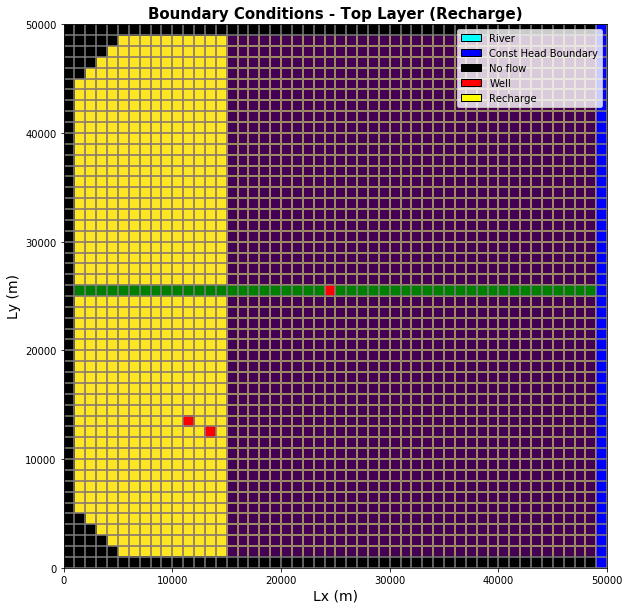

In [8]:
#CHECK BOUNDARY CONDITIONS
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#zones = ET_zone + rech_zone
#quadmesh = modelmap.plot_array(zones)
recharge = modelmap.plot_array((recharge_zone), color = 'orange')
#ET = modelmap.plot_array(ET_zone)
riv_plot = modelmap.plot_bc(ftype='RIV')
wel_plot = modelmap.plot_bc(ftype='WEL')
quadmesh = modelmap.plot_ibound()

#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Boundary Conditions - Top Layer (Recharge)', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='cyan',label='River',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   #mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='No flow',ec='black'),
                   mp.patches.Patch(color='Red',label='Well',ec='black'),
                    mp.patches.Patch(color='yellow',label='Recharge',ec='black')])
                   #mp.patches.Patch(color='Yellow',label='Riparian Area',ec='black'),
                   #mp.patches.Patch(color='cyan',label='Right ET',ec='black')])

### Cross section of the layered model
For more examples of cross section plotting check out this notebook: https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb 

C:\Users\HG\Anaconda3\lib\site-packages\flopy\plot\plotbase.py:368: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plotarray[idx] = 1


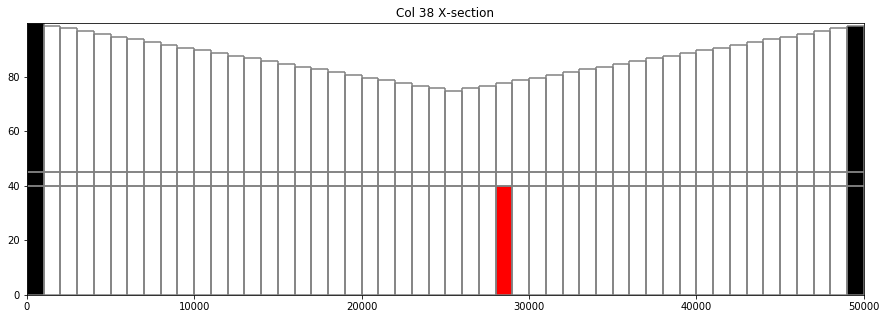

In [9]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 37}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='black', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='gray')
t = ax.set_title('Col 38 X-section')

# 5. Read in the outputs

###  Heads and budget files

In [10]:
       #extract binary data from head file for scenario 1 (steady state)
# times = [0] #extract times at end of each stress period
# head = {} #create dictionary to store head data at end of each stress period
# frf = {} #create dictionary to store flows through right cell face at end of each stress period
# fff = {} #create dictionary to store flows through front cell face at end of each stress period
# storage = {} #create dictionary to store storage at end of each stress period
# consthead = {} #create dictionary to store constant head boundary at end of each stress period
# leakage = {} #create dictionary to store leakage at end of each stress period

#get data from python objects
# head = headobj.get_data(totim=1.0) #append heads to head list for ea stress per
# frf = budgobj.get_data(text='FLOW RIGHT FACE',totim=1.0) #append right face flow to frf list for ea stress per
# fff = budgobj.get_data(text='FLOW FRONT FACE',totim=1.0) #append front face flow to fff list for ea stress per
# #storage = budgobj.get_data(text='STORAGE',totim=1.0) #append front face flow to fff list for ea stress per
# consthead = budgobj.get_data(text='CONSTANT HEAD',totim=1.0) #append front face flow to fff list for ea stress per
# leakage = budgobj.get_data(text='RIVER LEAKAGE',totim=1.0) #append front face flow to fff list for ea stress per

#print(leakage)

# with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
#     writer = csv.writer(csvfile, delimiter=',')        
#     for i in range(len(head[0,:,0])):                    #writes each row
#         writer.writerow(head[0,i,:])
 
    # Transient run - scenario 2

modelname = "scena2"
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times()    #returns a list of timesteps  
#times2 = [perlen[0],perlen[0]+perlen[1],perlen[0]+perlen[1]+perlen[2]] 
#print(times2)

  # extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period


headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

   


#get data from python objects
for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) #append right face flow to frf list for ea stress per
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per


    # Head - 3 layer case
#headobj = bf.HeadFile(modelname1+'.hds')    #reads the binary head file
#times = headobj.get_times()                #returns a list of timesteps
#head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)


    # Water balance - 3 layer case
#budgobj = bf.CellBudgetFile(modelname1+'.cbc')   #reads the cell budget file    
#print(budgobj.get_unique_record_names())
#kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
#frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
#fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
#recharge = budgobj.get_data(text='RECHARGE', totim=1.0) 
#print(len(frf))


In [11]:
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
leakage = budgobj.get_data(text='RIVER LEAKAGE',totim=1)
#print(leakage[0])
flux = np.array(range(nper))

for i in range(nper): ##print("Stream Leakage for Stress period %s"%i)
    perflux = 0
    for k in range(len(leakage[0])):
        #print(leakage['sp%s'%i][0][k][1])
        #perflux = perflux + leakage['sp%s'%i][0][k][1]
        flux[i] = flux[i] + leakage[0][k][1]
    #print(perflux)
print(flux)    

[14212 14213 14214 14215 14216 14217 14218 14219 14220 14221 14222 14223
 14224 14225 14226 14227 14228 14229 14230 14231 14232 14233 14234 14235
 14236 14237 14238 14239 14240 14241 14242 14243 14244 14245 14246 14247
 14248 14249 14250 14251 14252 14253 14254 14255 14256 14257 14258 14259
 14260 14261 14262 14263 14264 14265 14266 14267 14268 14269 14270 14271
 14272 14273 14274 14275 14276 14277 14278 14279 14280 14281 14282 14283
 14284 14285 14286 14287 14288 14289 14290 14291 14292 14293 14294 14295
 14296 14297 14298 14299 14300 14301 14302 14303 14304 14305 14306 14307
 14308 14309 14310 14311 14312 14313 14314 14315 14316 14317 14318 14319
 14320 14321 14322 14323 14324 14325 14326 14327 14328 14329 14330 14331
 14332 14333 14334 14335 14336 14337 14338 14338 14339 14340 14341 14342
 14343 14344 14345 14346 14347 14348 14349 14350 14351 14352 14353 14354
 14355 14356 14357 14358 14359 14360 14361]


## 6. Plot head transect

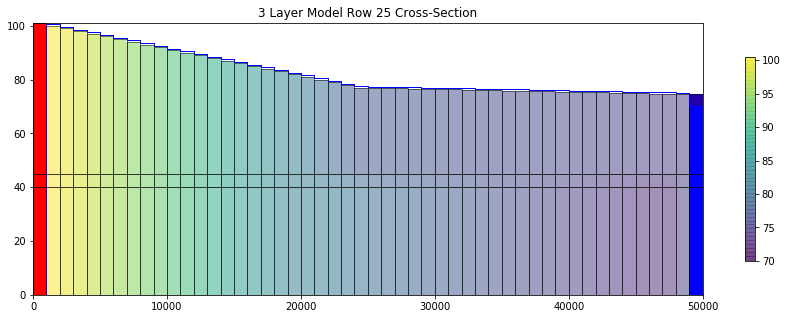

In [12]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

pc = xsect.plot_array(head['sp0'], masked_values=[-999.99], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head['sp0'])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head['sp0'][0,:,:], masked_values=[999.], color='blue', lw=1)

### Plot : head in wells 

In [13]:


#plot a time series at both monitoring wells
#get time series for a certain cell
#print(well_loc)

cell_id1 = (0,25.0,25.0) #cell ID of MW1
cell_id2 = (0,36.0,11.0) #cell ID of MW2
ag_id = (0,37.0, 13.0)#cell ID of ag well
agua_id = (2, 28.0, 37.0) #Cell ID of aguaseca community well
time_series1 = headobj.get_ts(cell_id1) #get the time series at MW1 using flopy
time_series2 = headobj.get_ts(cell_id2) #get the time series at MW2
time_series_ag = headobj.get_ts(ag_id) #get the time series at ag well
time_series_agua = headobj.get_ts(agua_id) #get the time series at aguaseca com well

#len(time_series1)
yearly_time_series1 = []
yearly_time_series1_head = []
#counter = 0
for i in range(0,27001,360):
    temp = time_series1[i]
    yearly_time_series1.append(temp[0])
    yearly_time_series1_head.append(temp[1])
    #yearly_time_series1.append(time_series1[i])
#print(time_series_ag)

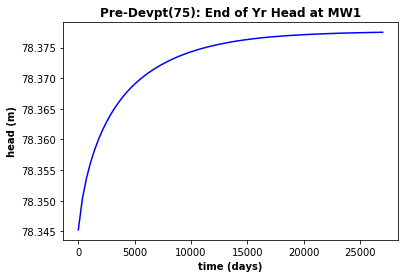

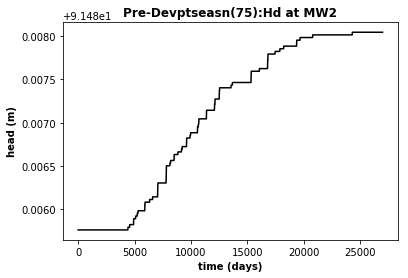

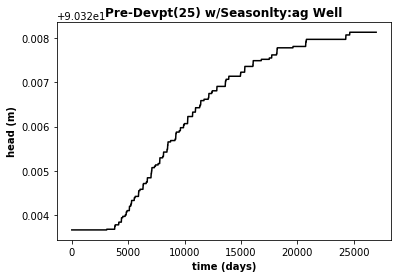

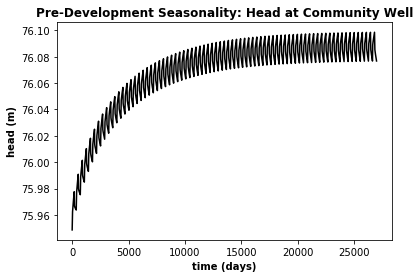

In [14]:
#create plot of MW1
plt.subplot(1, 1, 1)
plt.title("Pre-Devpt(75): End of Yr Head at MW1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(yearly_time_series1, yearly_time_series1_head, 'b-') #plot the time series with points at each record
plt.show()

#create plot of MW2
plt.subplot(1, 1, 1)
plt.title("Pre-Devptseasn(75):Hd at MW2",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series2[:, 0], time_series2[:, 1], 'k-') #plot the time series with points at each record
plt.show()

#create plot of Ag well
plt.subplot(1, 1, 1)
plt.title("Pre-Devpt(25) w/Seasonlty:ag Well",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_ag[:, 0], time_series_ag[:, 1], 'k-') #plot the time series with points at each record
plt.show()

#create plot of Aguaseca com well
plt.subplot(1, 1, 1)
plt.title("Pre-Development Seasonality: Head at Community Well",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_agua[:, 0], time_series_agua[:, 1], 'k-') #plot the time series with points at each record
plt.show()

In [15]:
#len(time_series1)
yearly_time_series1 = []

for i in range(0,27001,360):
    temp = time_series1[i]
    temp2 = temp[1]
    #yearly_time_series1.append(temp[1])
    yearly_time_series1.append(time_series1[i])

#print(yearly_time_series1)

In [ ]:
print(yearly_time_series1)
#print(temp[1])
#type(temmp)
#type(temp2)
#print(counter)    



### head transect 

In [ ]:
# fig4 = plt.figure() 
# ax = fig4.add_subplot(1, 1, 1)

# x=np.arange(0,50000,1000) 
# plt.plot(x,head[2,int(well_1_row),:],marker='o', color='green', markersize=4, linestyle='--', label="bottom layer")
# plt.plot(x,head[0,int(well_1_row),:],marker='o', color='blue', markersize=4, linestyle='--', label="top layer")
# plt.title('Head transect')
# plt.xlabel('X location')
# plt.ylabel('Head')
# plt.legend()
# plt.savefig('Head_Transect.png')

